In [21]:
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes
from skimage import io, color, measure, morphology
import numpy as np
def process_and_crop_image(image_path, output_folder):
    """
    Processes an image, crops the breast region, and saves the cropped image.

    Parameters:
    - image_path: str, path to the input image.
    - output_folder: str, folder where the cropped images will be saved.
    
    Returns:
    - cropped_image_path: str, path to the saved cropped image if processing was successful, otherwise None.
    """
    try:
        # Load the image
        image = io.imread(image_path)

        # Ensure the image is in grayscale
        if len(image.shape) > 2:
            image = color.rgb2gray(image)

        # Threshold the image
        thresh = threshold_otsu(image)
        binary = image > thresh

        # Perform morphological operations to remove small objects/noise
        cleaned = morphology.remove_small_objects(binary, min_size=150)

        # Fill the holes to keep internal structures
        filled_image = binary_fill_holes(cleaned)

        # Label the image
        label_img = measure.label(filled_image)
        regions = measure.regionprops(label_img)

        # If no regions are detected, return None
        if not regions:
            return None

        # Assuming the largest region is the breast, we select it
        region_max = max(regions, key=lambda r: r.area)

        # Get the bounding box of the largest region
        minr, minc, maxr, maxc = region_max.bbox
        cropped_image = image[minr:maxr, minc:maxc]

        # Define the output path
        filename = os.path.basename(image_path)
        cropped_image_path = os.path.join(output_folder, f"cropped_{filename}")
        
        # Save the cropped image
        io.imsave(cropped_image_path, cropped_image.astype(np.uint8))
        
        return cropped_image_path
    except Exception as e:
        # If there was an error during processing, return None
        print(f"Error processing {image_path}: {e}")
        return None



In [24]:
def apply_voi_lut(image, window_width, window_level):
    """
    Apply VOI LUT to an image based on the specified window width and window level.
    
    Parameters:
    - image: A numpy array representing the input image.
    - window_width: The width of the window (contrast).
    - window_level: The level of the window (brightness).
    
    Returns:
    - A numpy array representing the image after applying the VOI LUT.
    """
    # Calculate the lower and upper threshold
    lower = window_level - (window_width / 2)
    upper = window_level + (window_width / 2)

    # Apply the VOI LUT transformation
    voi_lut_image = np.clip(image, lower, upper)
    voi_lut_image = np.uint8((voi_lut_image - lower) / window_width * 255)
    
    return voi_lut_image

In [52]:
import os
# Process and crop each image in the input folder
output_folder = '../data/cropped_voi_lut/'
input_folder = '../data/'
tmp= '../data/tmp/'
# Example window level and window width values
window_level = 80  # This is an arbitrary value
window_width = 300  # This is an arbitrary value

processed_images_paths = []
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')) and not filename.startswith('cropped_'):
        image_path = os.path.join(input_folder, filename)
        processed_image_path = process_and_crop_image(image_path, tmp)
        if processed_image_path:
            # Load the cropped image
            cropped_image = io.imread(processed_image_path)
            # Apply VOI LUT to the cropped image
            voi_lut_image = apply_voi_lut(cropped_image, window_width, window_level)
            # Save the VOI LUT applied image
            voi_lut_image_path = processed_image_path.replace('cropped_', '')
            io.imsave(voi_lut_image_path.replace('tmp','cropped_voi_lut'), voi_lut_image)
            processed_images_paths.append(voi_lut_image_path)

/var/folders/_b/jv2s0mt50pb619n1x3lfx7240000gp/T/ipykernel_59298/279742341.py:50: UserWarning: ../data/tmp/cropped_822_1942326353.png is a low contrast image
  io.imsave(cropped_image_path, cropped_image.astype(np.uint8))
/var/folders/_b/jv2s0mt50pb619n1x3lfx7240000gp/T/ipykernel_59298/3314478486.py:22: UserWarning: ../data/cropped_voi_lut/822_1942326353.png is a low contrast image
  io.imsave(voi_lut_image_path.replace('tmp','cropped_voi_lut'), voi_lut_image)


In [43]:
from skimage import io, color, measure, morphology
import numpy as np
import matplotlib.pyplot as plt

# Define the VOI LUT function
def apply_voi_lut(image, window_width, window_level):
    lower = window_level - (window_width / 2)
    upper = window_level + (window_width / 2)
    voi_lut_image = np.clip(image, lower, upper)
    voi_lut_image = np.uint8((voi_lut_image - lower) / window_width * 255)
    return voi_lut_image

def plo_voi_lut(image_path):
    # Define sets of window levels and widths for permutation
    window_levels = [10, 20,40, 60, 80,100,120,140,160]
    window_widths = [50,100,150,200,250,300,350, 400, 450]
    window_levels = [ 60, 70, 80]
    window_widths = [200,250,300]
    image = io.imread(image_path)
    
    # Ensure the image is in grayscale
    if len(image.shape) > 2:
        image = color.rgb2gray(image)
    
    # Apply the different permutations of window level and window width
    output_images = {}
    for wl in window_levels:
        for ww in window_widths:
            # Apply the VOI LUT
            voi_lut_image = apply_voi_lut(image, ww, wl)
            output_image_path = f'../data/c+v/voi_lut_wl{wl}_ww{ww}.png'
            io.imsave(output_image_path, voi_lut_image)
            output_images[(wl, ww)] = output_image_path
    
    # Display a subset of the images
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for idx, ((wl, ww), image_path) in enumerate(output_images.items()):
        ax = axes[idx // 3, idx % 3]
        ax.imshow(io.imread(image_path), cmap='gray')
        ax.axis('off')
        ax.set_title(f"WL: {wl}, WW: {ww}")
    plt.tight_layout()
    plt.show()


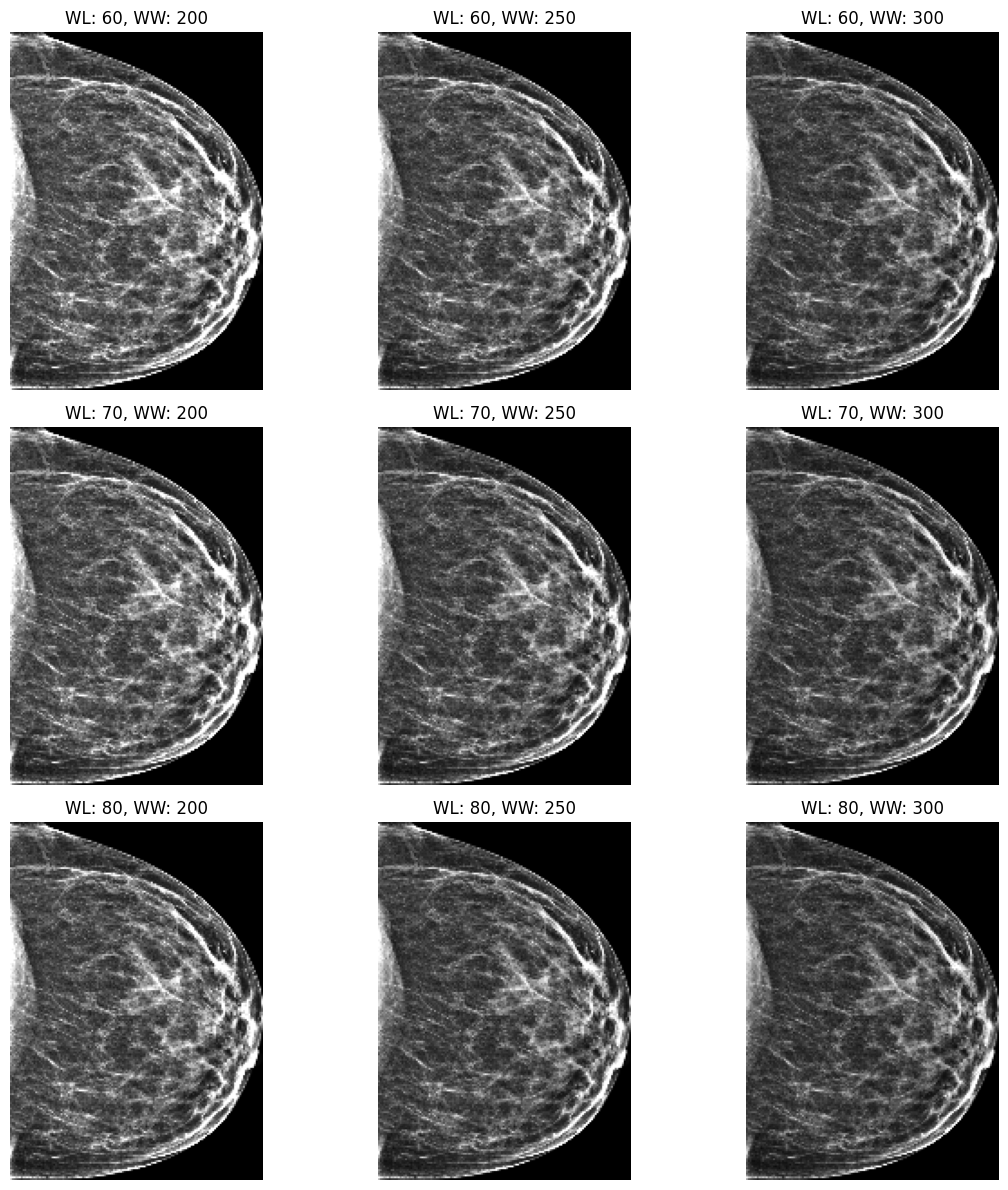

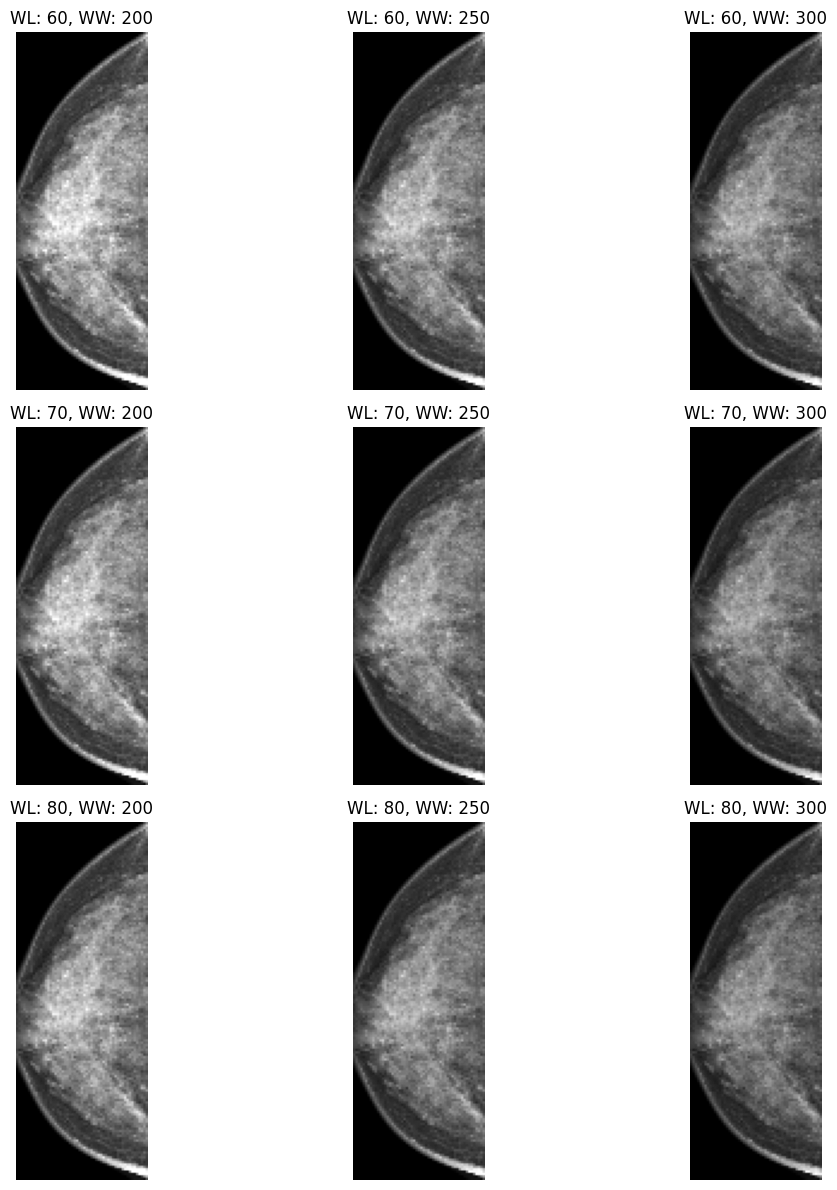

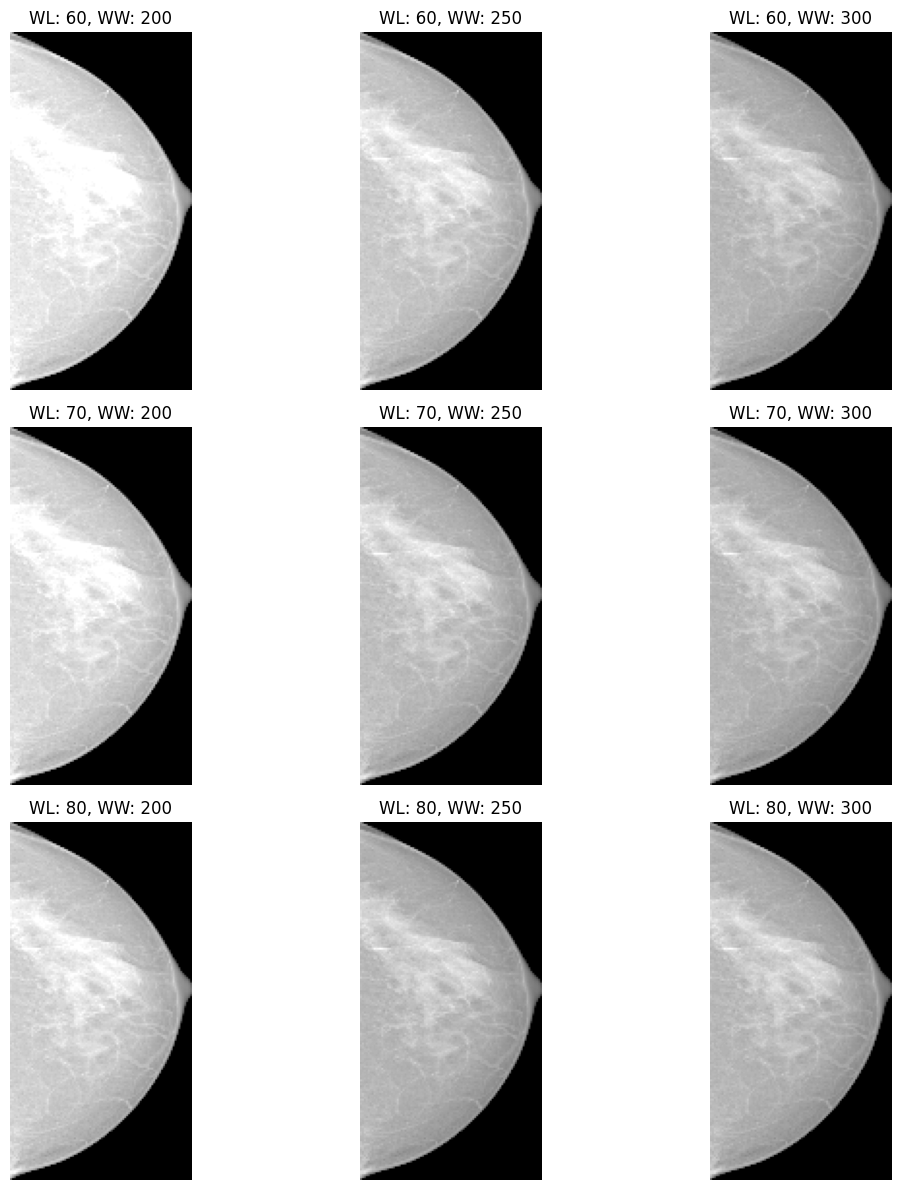

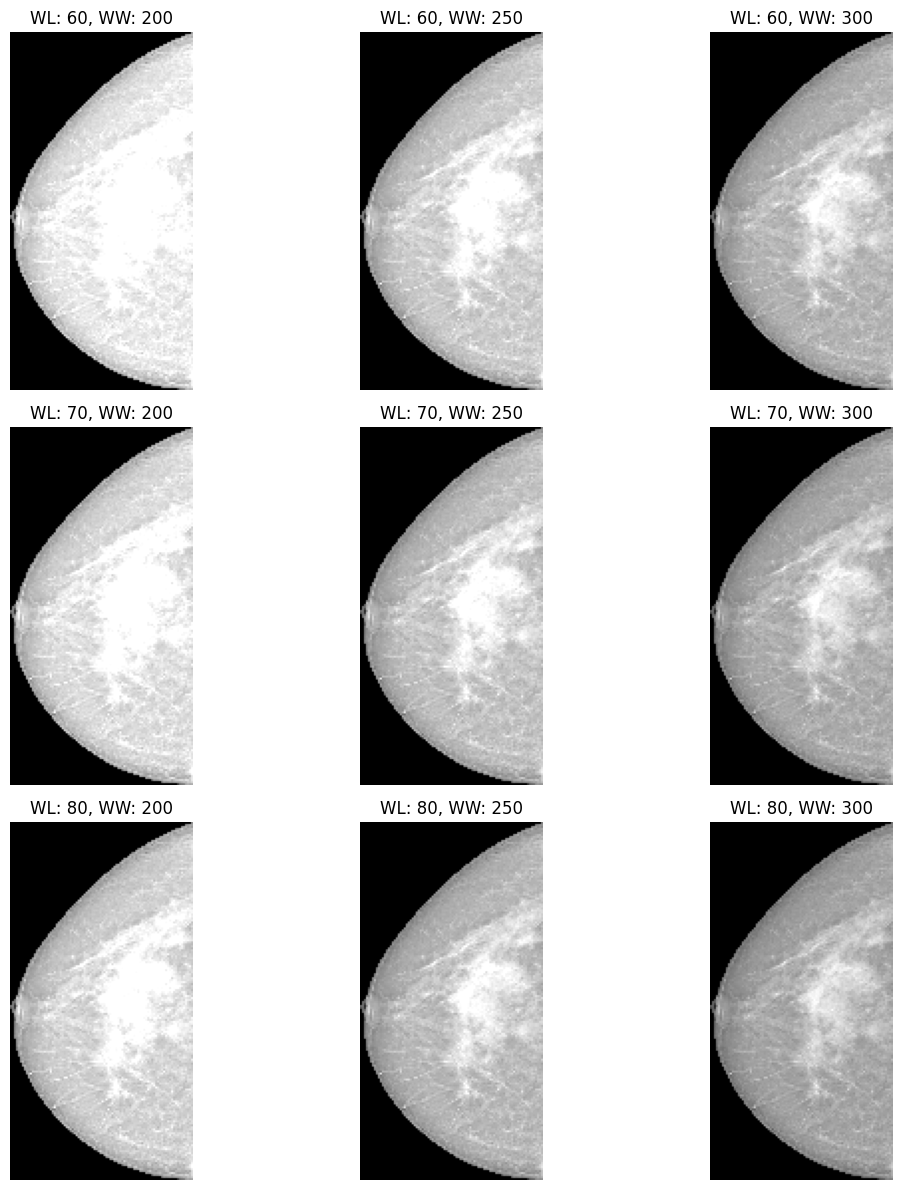

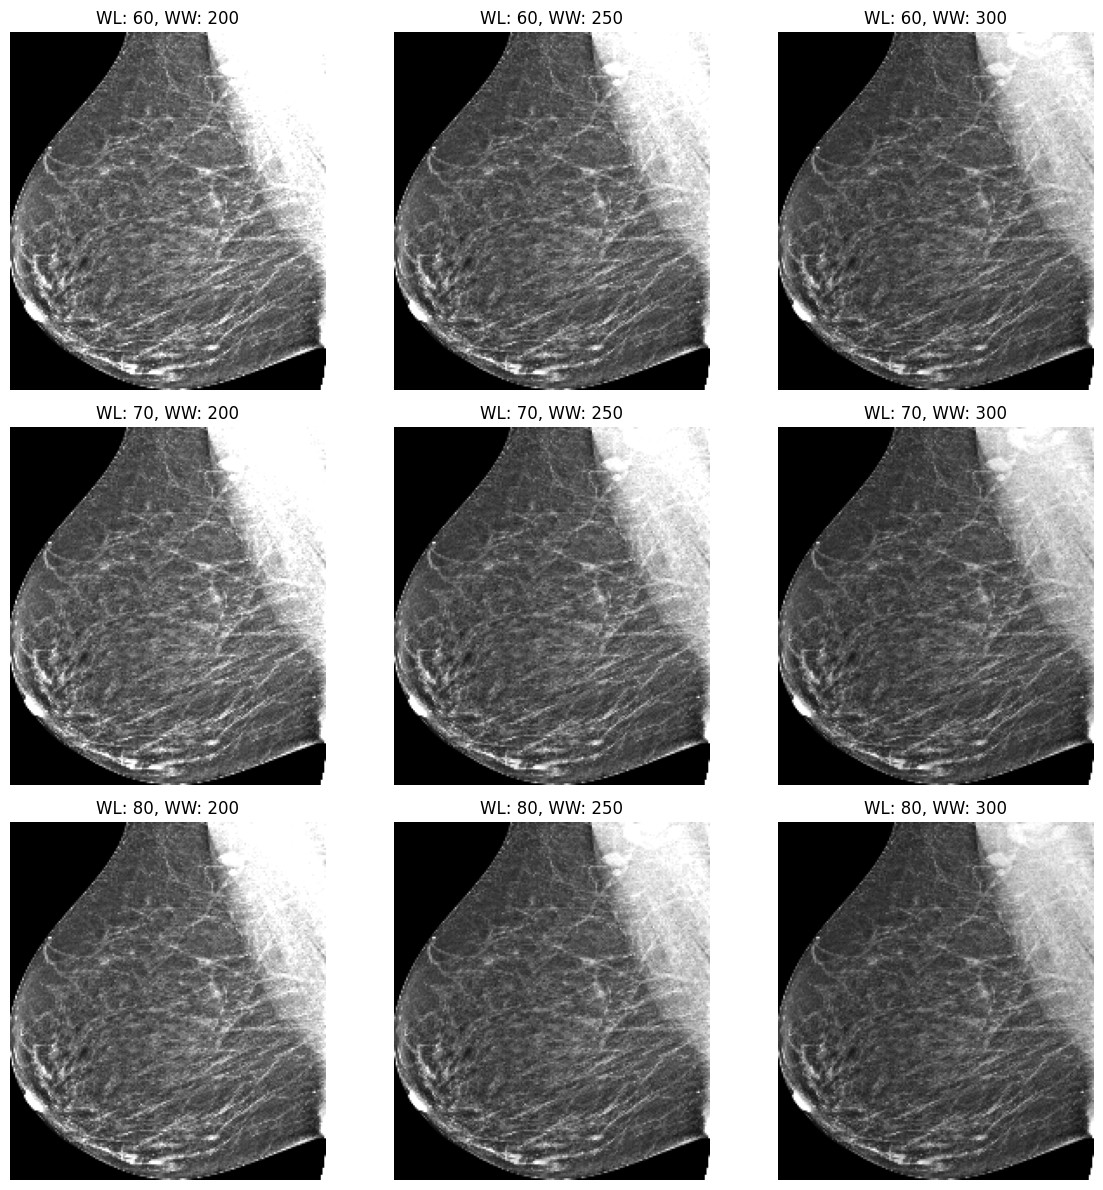

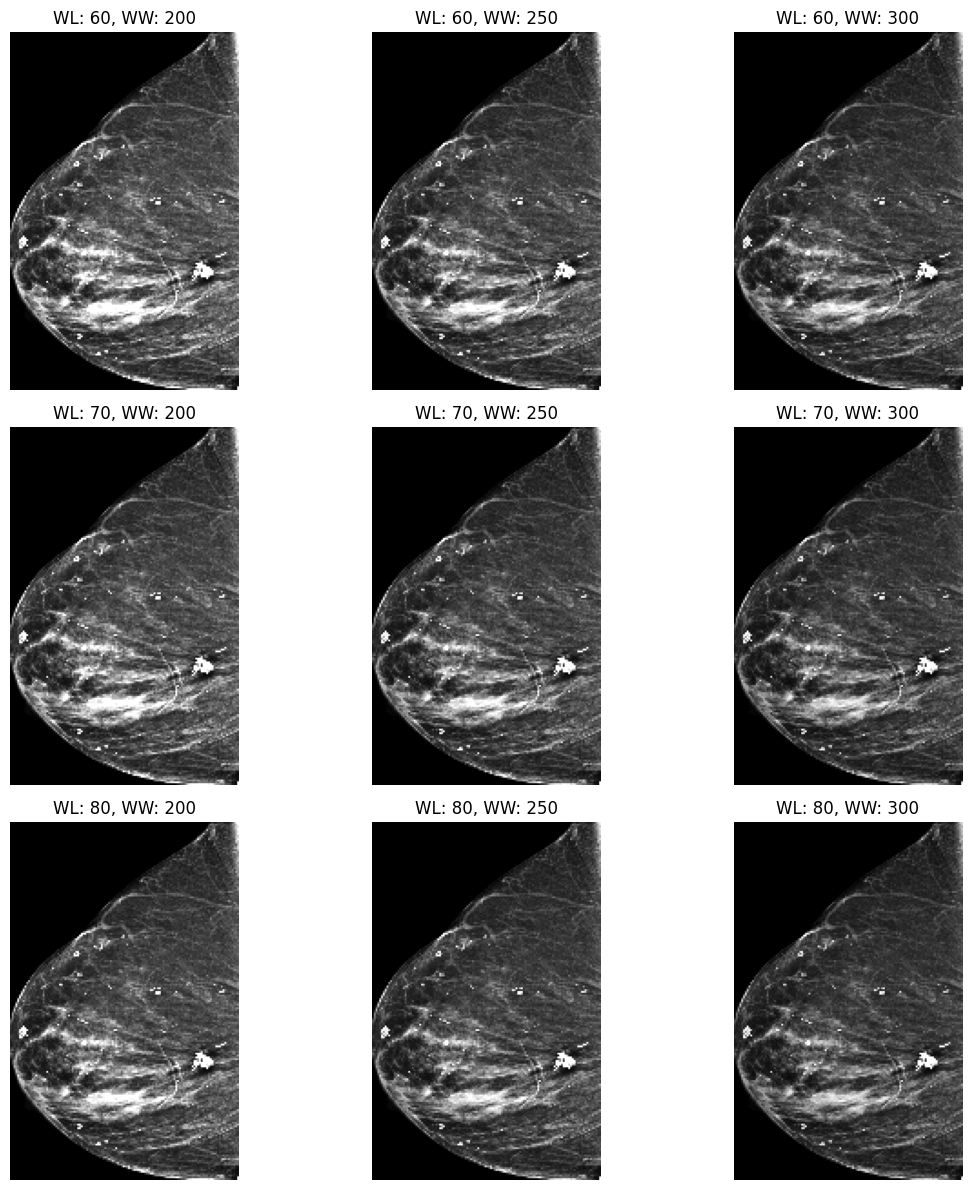

In [46]:
plo_voi_lut('/Users/xgxtphg/Documents/git/SimpleNet/data/cropped/cropped_28_825270681.png')
plo_voi_lut('/Users/xgxtphg/Documents/git/SimpleNet/data/cropped/cropped_36_200779059.png')
plo_voi_lut('/Users/xgxtphg/Documents/git/SimpleNet/data/cropped/cropped_30_1153448462.png')
plo_voi_lut('/Users/xgxtphg/Documents/git/SimpleNet/data/cropped/cropped_105_1934323665.png')
plo_voi_lut('/Users/xgxtphg/Documents/git/SimpleNet/data/cropped/cropped_243_712682632.png')
plo_voi_lut('/Users/xgxtphg/Documents/git/SimpleNet/data/cropped/cropped_10130_388811999.png')